**AIML Online Capstone - Pneumonia Detection Challenge**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

Details about the data and dataset files are given in below link,

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

Given we are dealing with Medical images. Hence it is Important to install pydicom for reading DICOM files

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 6.6 MB/s 


In [ ]:
#Load all the necessary data libraries

import numpy as np # Linear Algebra
import pydicom # to read the Dicom files
import pandas as pd # to read the database
import seaborn as sns
import matplotlib as mpl
import multiprocessing
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import os

pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['lines.linewidth'] = 4.5

#To avoid or ignore any warnings
import warnings
warnings.filterwarnings('ignore')
print("All the Warnings are ignored!!")

All the Warnings are ignored!!


In [ ]:
#To mount the Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#To change the directory
filepath = '/content/drive/MyDrive/Capstone Project/rsna-pneumonia-detection-challenge/'
os.chdir(filepath)
!pwd

/content/drive/MyDrive/Capstone Project/rsna-pneumonia-detection-challenge


In [ ]:
ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images/
 Mixed_link_model.h5                    stage_2_train_images/
 stage_2_detailed_class_info.csv        stage_2_train_images.zip/
 stage_2_sample_submission.csv          stage_2_train_labels.csv


In [ ]:
#To import and read our data files
class_data = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_data = pd.read_csv('stage_2_train_labels.csv')

In [ ]:
class_data.head (5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
train_labels_data.head (5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,nan,nan,nan,nan,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,nan,nan,nan,nan,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,nan,nan,nan,nan,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,nan,nan,nan,nan,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.00,152.00,213.00,379.00,1


In [ ]:
class_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
train_labels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
#To print shape
class_data.shape

(30227, 2)

In [ ]:
#To print shape
train_labels_data.shape

(30227, 6)

In [ ]:
print('Total number of rows per patient:', train_labels_data.shape[0])
print('Total number of unique patient Ids:', train_labels_data['patientId'].nunique())

Total number of rows per patient: 30227
Total number of unique patient Ids: 26684


From the above, we have explored that in the file class detailed info we have detailed information on the type of positive or negative class for each patient.

Similarl, in the file train labels we have the patient ID and the details of x min, y min, width and height of the bounding box providing the evidence of pneumonia infection.

**PERFORMING EXPLORATORY DATA ANALYSIS (EDA)**

In [ ]:
#To prepare our dataset let us identify the missing data in our files
#Firstly, we will sort our data

def missing_data(data):
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
  return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

missing_data(class_data)

,class,patientId
Total,0.00,0.00
Percent,0.00,0.00


In [ ]:
# for the train labels file

missing_data(train_labels_data)

,height,width,y,x,Target,patientId
Total,20672.00,20672.00,20672.00,20672.00,0.00,0.00
Percent,68.39,68.39,68.39,68.39,0.00,0.00


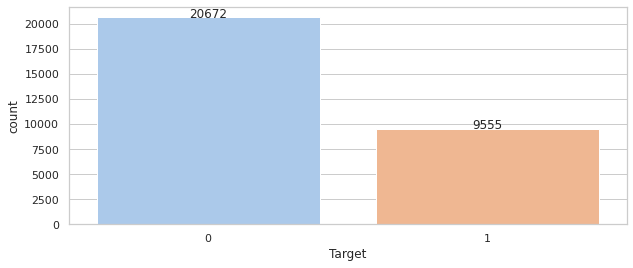

In [ ]:
#Let us plot the distribution
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['lines.linewidth'] = 2

def countPlot(target="Target"):
    ax = sns.countplot(x=target, data=train_labels_data, palette="pastel")

    for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.400, p.get_height()+0.20), ha='center')

    plt.show()

countPlot("Target")


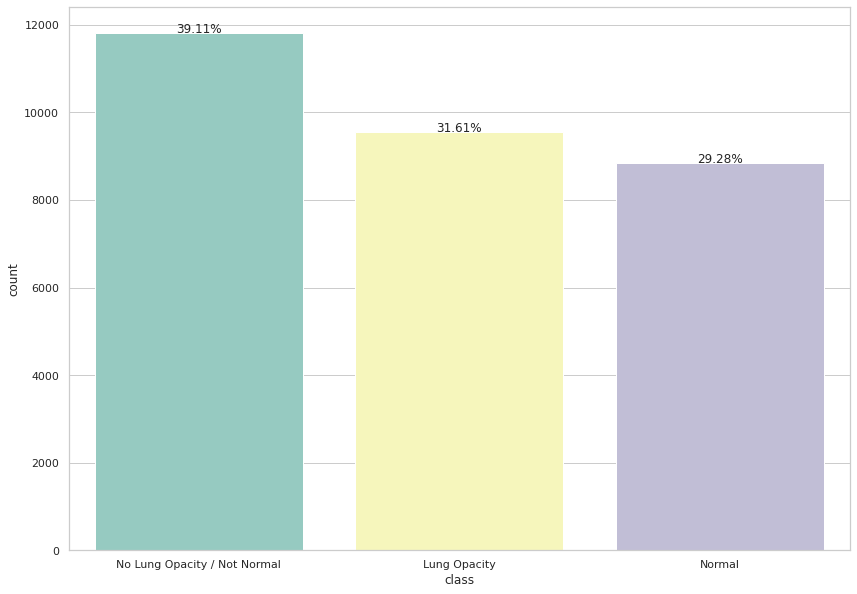

In [ ]:
#To plot the 3 categories of the class
f, ax = plt.subplots(1,1, figsize=(14,10))
total = float(len(class_data))
sns.countplot(class_data['class'],order = class_data['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [ ]:
#To get more details of the different classes
def get_feature_distribution(data, feature):
    
    # To get the count for each label
    label_counts = data[feature].value_counts()

    # To get total number of samples
    total_samples = len(data)

    # To count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_data, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


**Merge train and class detail info data**

In [ ]:
#Let us merge the two datasets into one file using Patient Id
assert train_labels_data['patientId'].values.tolist() == class_data['patientId'].values.tolist(), 'patientId columns are different.'
Merged_data = pd.concat([train_labels_data, class_data.drop(labels=['patientId'], axis=1)], axis=1)
Merged_data.shape

(30227, 7)

In [ ]:
Merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


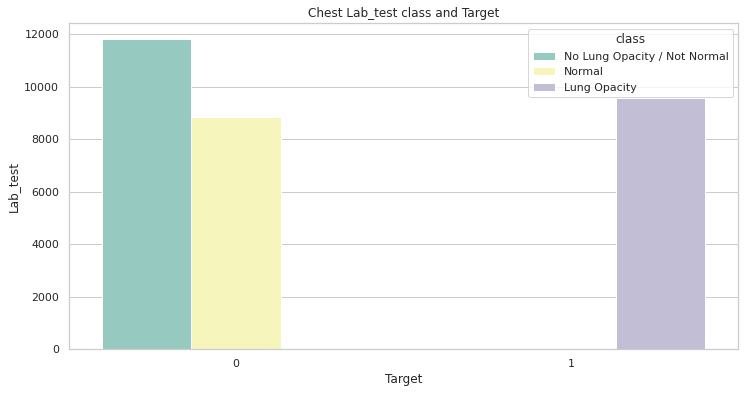

In [ ]:
#Let us now plot the number of Lab test done by each class and group it by Target

fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = Merged_data.groupby('Target')['class'].value_counts()
data = pd.DataFrame(data={'Lab_test': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Lab_test',hue='class',data=data, palette='Set3')
plt.title("Chest Lab_test class and Target")
plt.show()

**From the above graph it is clear that, where Target=1, Pathology is detected, Class is Lung Opacity.**

**And for Target=0, Pathology is not detected, Class is either Normal or No Lung Opacity / Not Normal**

<Figure size 720x288 with 0 Axes>

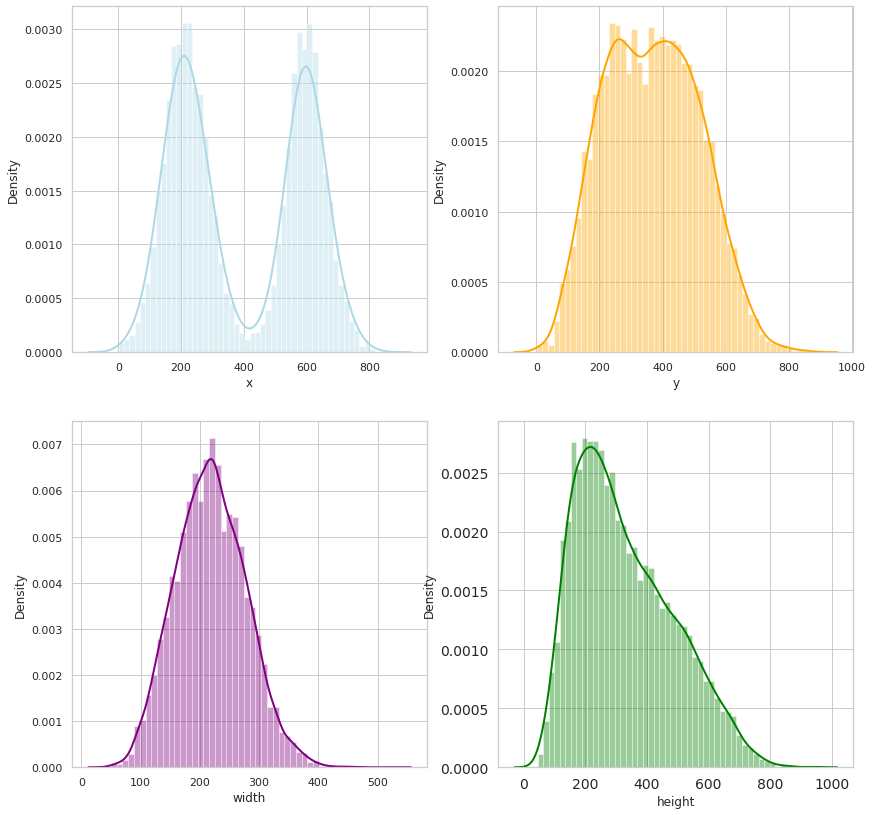

In [ ]:
#Let us plot distribution for Target = 1, using our merged data
target1 = Merged_data[Merged_data['Target']==1]
sns.set_style('whitegrid')
plt.figure()
f, ax = plt.subplots(2,2,figsize=(14,14))
sns.distplot(target1['x'],kde=True,bins=50, color="lightblue", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="orange", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="purple", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="green", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

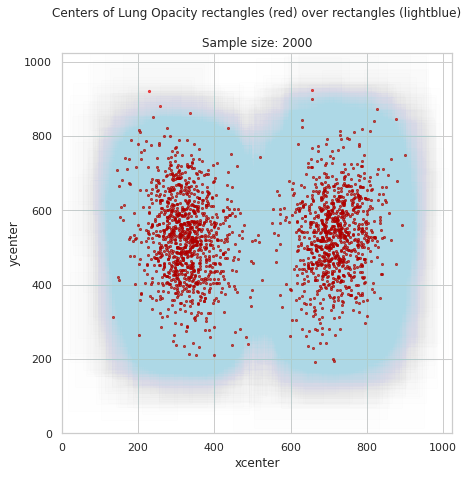

In [ ]:
#Now, let us also plot the corresponding sample of rectangles
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xcenter'] = target_sample['x'] + target_sample['width'] / 2
target_sample['ycenter'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (red) over rectangles (lightblue)\n\nSample size: 2000")
target_sample.plot.scatter(x='xcenter', y='ycenter', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.7, marker=".", color="red")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="lightblue"))
plt.show()

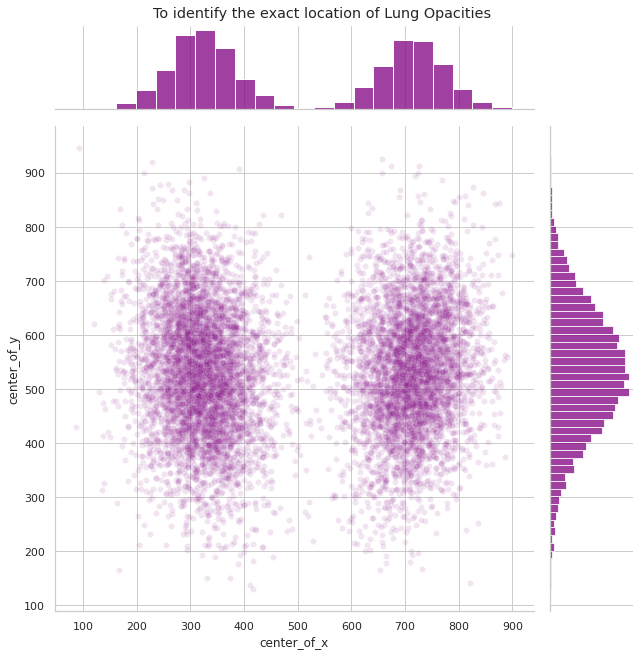

In [ ]:
#To identify the location of Lung Opacities
tr = Merged_data[Merged_data['Target']==1]
centers_location = (tr.dropna(subset=['x'])
           .assign(center_of_x=tr.x + tr.width / 2, center_of_y=tr.y + tr.height / 2))
ax = sns.jointplot("center_of_x", "center_of_y", data=centers_location, height=9, alpha=0.1,color="purple")
_ = ax.fig.suptitle("To identify the exact location of Lung Opacities", y=1.01)

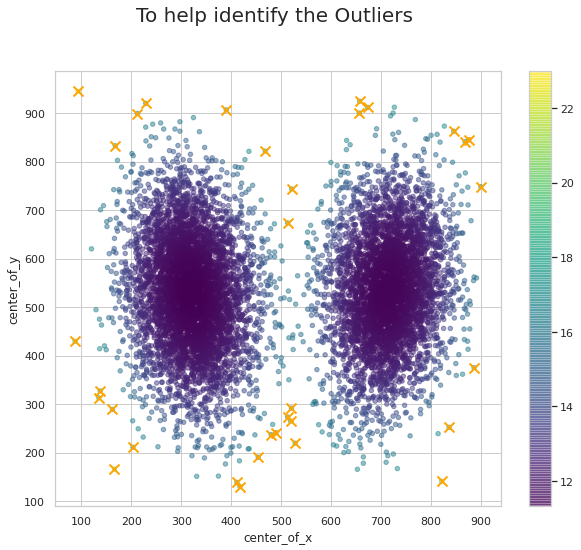

In [ ]:
#To identify the outliers
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers_location[['center_of_x', 'center_of_y']])
center_probs = clf.predict_proba(centers_location[['center_of_x', 'center_of_y']])
Z = -clf.score_samples(centers_location[['center_of_x', 'center_of_y']])
outliers = centers_location.iloc[Z > 17]
f, ax = plt.subplots(1,1,figsize=(10,8))
centers_location.plot.scatter('center_of_x', 'center_of_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
outliers.plot.scatter('center_of_x', 'center_of_y', c='orange', marker='x', s=100, ax=ax)
_ = ax.set_title('To help identify the Outliers \n\n', fontsize=20)

In [ ]:
#Now, we will visualise the DICOM data
sample_image_loc = os.listdir('stage_2_train_images')[:5]
print(sample_image_loc)

['08a5a06e-f9a5-4e0d-abd2-e4d8ee005fb7.dcm', '918762a3-791d-48f5-9b3b-9c149ed72264.dcm', '73212dc5-6535-4837-838b-f08aff61c1a3.dcm', '239b10e6-a859-447b-8496-eca7b6c8a356.dcm', 'ff30520c-68c9-4d17-acb0-f44eb1f4eb1c.dcm']


In [ ]:
train_image = os.listdir('stage_2_train_images')
test_image = os.listdir('stage_2_test_images')
print("Total number of images in the train dataset:", len(train_image),"\n\nTotal number of images in test dataset:", len(test_image))

Total number of images in the train dataset: 26687 

Total number of images in test dataset: 3009


In [ ]:
print("Unique patientId in  train_labels_data: ", train_labels_data['patientId'].nunique())

Unique patientId in  train_labels_data:  26684


In [ ]:
tmp = Merged_data.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Lab_test': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Lab_test','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Lab_test', 'Target','Class', 'Entries']
df2

,Lab_test,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,2,1,Lung Opacity,3266
4,3,1,Lung Opacity,119
5,4,1,Lung Opacity,13


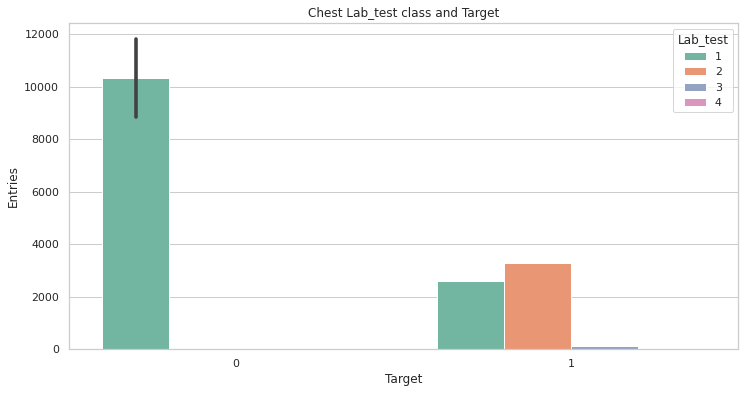

In [ ]:
f, ax = plt.subplots(nrows=1,figsize=(12,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Lab_test',data=df2, palette='Set2')
plt.title("Chest Lab_test class and Target")
plt.show()

In [ ]:
import pydicom as dcm

samplePatientID = list(train_labels_data[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

**MODEL BUILDING**

In [ ]:
#Let us import the relevant libraries for model building
import csv
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Firstly, we will empty the dictionary
PATH = ''
pneumonia_locations = {}
# to load table
with open(os.path.join(PATH+'stage_2_train_labels.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if our row contains pneumonia add label to dictionary which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # we need to convert string to float to int
            location = [int(float(i)) for i in location]
            # to save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]


In [ ]:
# To load and shuffle filenames
folder = PATH+'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# to split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

n train samples 24127
n valid samples 2560
Total train images: 26687
Images with pneumonia: 6012


In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # to load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # to create an empty mask
        msk = np.zeros(img.shape)
        # to get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia

        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # to resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        img = np.array(img).astype(np.float32)
        msk = np.array(msk).astype(np.float32)
        
        

        # to add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # to load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # to resize image
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        # to add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # Let us select batch size
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # to predict mode: return images and filenames
        if self.predict:
            # first we would load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # again load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # to create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # to return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # to return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)

    #Added Start
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    #Added End
    
    addInput = x;
    print("Add input shape:", addInput.shape)
    print("Resnet block input shape:", inputs.shape)
    resBlockOut = keras.layers.add([addInput, inputs])
    print("Resnet block out shape:", resBlockOut.shape)
    out = keras.layers.concatenate([resBlockOut, addInput], axis=3)
    print("concat block out shape:", out.shape)
    out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out)
    print("mixed block out shape:", out.shape)
    return out

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Next, we will define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
folder = PATH+'stage_2_train_images'
train_gen = generator(folder, train_filenames[0:1000], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames[1000:1200], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)


In [ ]:
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
# to cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

Epoch 1/10
62/62 - 587s - loss: 0.5665 - accuracy: 0.9475 - mean_iou: 0.5918 - val_loss: 0.5205 - val_accuracy: 0.9638 - val_mean_iou: 0.5742 - lr: 0.0010 - 587s/epoch - 9s/step
Epoch 2/10
62/62 - 331s - loss: 0.5274 - accuracy: 0.9573 - mean_iou: 0.5850 - val_loss: 0.4995 - val_accuracy: 0.9686 - val_mean_iou: 0.5479 - lr: 9.9606e-04 - 331s/epoch - 5s/step
Epoch 3/10
62/62 - 333s - loss: 0.5152 - accuracy: 0.9554 - mean_iou: 0.5129 - val_loss: 0.5092 - val_accuracy: 0.9719 - val_mean_iou: 0.5755 - lr: 9.8429e-04 - 333s/epoch - 5s/step
Epoch 4/10
62/62 - 333s - loss: 0.5089 - accuracy: 0.9530 - mean_iou: 0.5116 - val_loss: 0.5423 - val_accuracy: 0.9760 - val_mean_iou: 0.7211 - lr: 9.6489e-04 - 333s/epoch - 5s/step
Epoch 5/10
62/62 - 335s - loss: 0.5070 - accuracy: 0.9581 - mean_iou: 0.5580 - val_loss: 0.4688 - val_accuracy: 0.9593 - val_mean_iou: 0.6052 - lr: 9.3815e-04 - 335s/epoch - 5s/step
Epoch 6/10
62/62 - 333s - loss: 0.4952 - accuracy: 0.9549 - mean_iou: 0.5350 - val_loss: 0.485

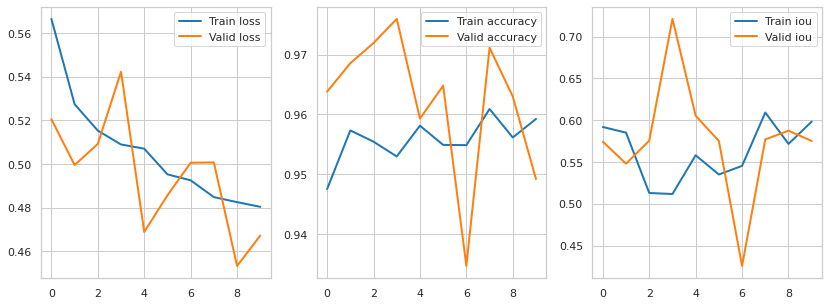

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
model.save(r'Mixed_link_model.h5')

In [ ]:
adm_accuracy = round(history.history.get('accuracy')[-1] * 100, 2)
adm_val_accuracy = round(history.history.get('val_accuracy')[-1] * 100, 2)
adm_loss = round(history.history.get('loss')[-1] * 100, 2)
adm_val_loss = round(history.history.get('val_loss')[-1] * 100, 2)
adm_mean_iou = round(history.history.get('mean_iou')[-1] * 100, 2)
adm_val_mean_iou = round(history.history.get('val_mean_iou')[-1] * 100, 2)
print(adm_accuracy, adm_val_accuracy, adm_loss, adm_val_loss, adm_mean_iou, adm_val_mean_iou)

95.92 94.92 48.03 46.71 59.83 57.51


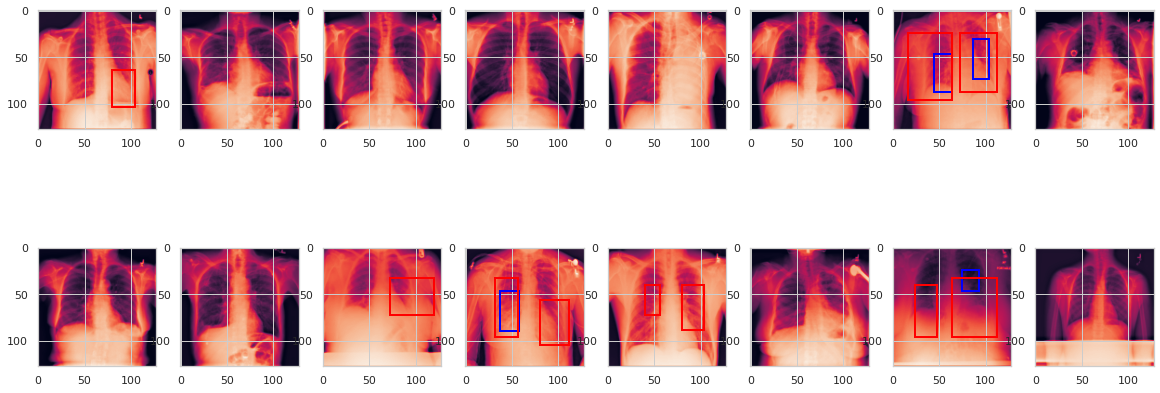

In [ ]:
for imgs, msks in valid_gen:
    # to predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(2, 8, figsize=(20,8))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [ ]:
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='SGD',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

Epoch 1/10
62/62 - 1106s - loss: 0.6433 - accuracy: 0.9596 - mean_iou: 0.1085 - val_loss: 0.6387 - val_accuracy: 0.9680 - val_mean_iou: 0.1391 - lr: 0.0010 - 1106s/epoch - 18s/step
Epoch 2/10
62/62 - 334s - loss: 0.6319 - accuracy: 0.9628 - mean_iou: 0.1999 - val_loss: 0.6266 - val_accuracy: 0.9698 - val_mean_iou: 0.2101 - lr: 9.9606e-04 - 334s/epoch - 5s/step
Epoch 3/10
62/62 - 337s - loss: 0.6223 - accuracy: 0.9652 - mean_iou: 0.2937 - val_loss: 0.6195 - val_accuracy: 0.9719 - val_mean_iou: 0.3194 - lr: 9.8429e-04 - 337s/epoch - 5s/step
Epoch 4/10
62/62 - 332s - loss: 0.6143 - accuracy: 0.9666 - mean_iou: 0.3889 - val_loss: 0.6092 - val_accuracy: 0.9735 - val_mean_iou: 0.3805 - lr: 9.6489e-04 - 332s/epoch - 5s/step
Epoch 5/10
62/62 - 332s - loss: 0.6071 - accuracy: 0.9675 - mean_iou: 0.4535 - val_loss: 0.6039 - val_accuracy: 0.9747 - val_mean_iou: 0.5099 - lr: 9.3815e-04 - 332s/epoch - 5s/step
Epoch 6/10
62/62 - 326s - loss: 0.6015 - accuracy: 0.9681 - mean_iou: 0.5013 - val_loss: 0.

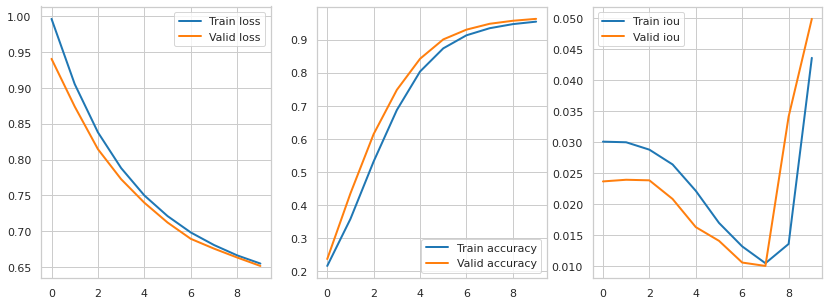

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
sgd_accuracy = round(history.history.get('accuracy')[-1] * 100, 2)
sgd_val_accuracy = round(history.history.get('val_accuracy')[-1] * 100, 2)
sgd_loss = round(history.history.get('loss')[-1] * 100, 2)
sgd_val_loss = round(history.history.get('val_loss')[-1] * 100, 2)
sgd_mean_iou = round(history.history.get('mean_iou')[-1] * 100, 2)
sgd_val_mean_iou = round(history.history.get('val_mean_iou')[-1] * 100, 2)

print(sgd_accuracy, sgd_val_accuracy, sgd_loss, sgd_val_loss, sgd_mean_iou, sgd_val_mean_iou)

95.41 96.25 65.46 65.12 4.36 4.99


In [ ]:
result = pd.DataFrame(
    {
        'Optimizer': ['ADAM', 'SGD '],
        'accuracy': [adm_accuracy,  sgd_accuracy],
        'val_accuracy': [adm_val_accuracy,  sgd_val_accuracy],
        'loss': [adm_loss, sgd_loss],
        'val_loss': [adm_val_loss, sgd_val_loss],
        'mean_iou': [adm_mean_iou, sgd_mean_iou],
        'val_mean_iou': [adm_val_mean_iou, sgd_val_mean_iou]
    })

result.sort_values(by=['accuracy', 'val_accuracy'], axis=0, ascending=True,
                    inplace=False, kind='quicksort', na_position='last')

result

,Optimizer,accuracy,val_accuracy,loss,val_loss,mean_iou,val_mean_iou
0,ADAM,95.92,94.92,48.03,46.71,59.83,57.51
1,SGD,95.41,96.25,65.46,65.12,4.36,4.99
